In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
============================
Linear OT mapping estimation
============================
"""

# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 2
import os
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import ot

import condo

epoch:0 -0.02304->-0.41886 avg:-0.16990
epoch:1 -0.40956->-0.51408 avg:-0.45272
epoch:2 -0.49059->-0.55108 avg:-0.50292
epoch:3 -0.54212->-0.50982 avg:-0.52944
epoch:4 -0.48553->-0.39101 avg:-0.52138
epoch:5 -0.50457->-0.43524 avg:-0.52789
epoch:6 -0.48073->-0.46989 avg:-0.50254
epoch:7 -0.51599->-0.47477 avg:-0.53015
epoch:8 -0.47861->-0.46968 avg:-0.53641
epoch:9 -0.50068->-0.56221 avg:-0.51595
epoch:10 -0.54418->-0.55504 avg:-0.53419
epoch:11 -0.49343->-0.49625 avg:-0.52282
epoch:12 -0.45668->-0.48185 avg:-0.51199
epoch:13 -0.43561->-0.52137 avg:-0.50218
epoch:14 -0.43582->-0.54674 avg:-0.49695
epoch:15 -0.52401->-0.54341 avg:-0.50107
epoch:16 -0.52176->-0.53678 avg:-0.50380
epoch:17 -0.42061->-0.44593 avg:-0.48200
epoch:18 -0.52129->-0.53629 avg:-0.50222
epoch:19 -0.51165->-0.43462 avg:-0.48950
(array([[0.69853628, 0.94061747],
       [0.17221   , 1.5787177 ]]), array([3.4855125 , 1.80811022]))


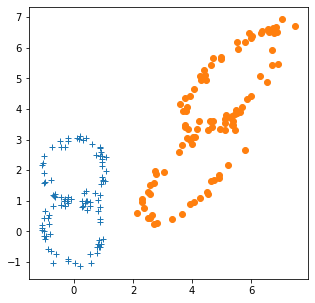

In [2]:
##############################################################################
# Generate data
# -------------

n = 100
d = 2
sigma = .1

rng = np.random.RandomState(42)

# source samples
angles = rng.rand(n, 1) * 2 * np.pi
xs = np.concatenate((np.sin(angles), np.cos(angles)),
                    axis=1) + sigma * rng.randn(n, 2)
xs[:n // 2, 1] += 2


# target samples
anglet = rng.rand(n, 1) * 2 * np.pi
xt = np.concatenate((np.sin(anglet), np.cos(anglet)),
                    axis=1) + sigma * rng.randn(n, 2)
xt[:n // 2, 1] += 2


A = np.array([[1.5, .7], [.7, 1.5]])
#A = np.array([[ 0.064,  1.117], [-1.485,  1.315]])
b = np.array([[4, 2]])
#b = np.array([3.564, 2.148])
xt = xt.dot(A) + b

##############################################################################
# Plot data
# ---------

plt.figure(1, (5, 5))
plt.plot(xs[:, 0], xs[:, 1], '+')
plt.plot(xt[:, 0], xt[:, 1], 'o')


##############################################################################
# Estimate linear mapping and transport
# -------------------------------------

Ae, be = ot.da.OT_mapping_linear(xs, xt)

xst = xs.dot(Ae) + be

cder = condo.ConDoAdapter(
    sampling="source",
    transform_type="affine",
    model_type="empirical",
    divergence="mmd",
    mmd_kwargs={"epochs": 20, "alpha": 0.1, "beta": 0.0},
    debug=False,
    verbose=1
)
ys = rng.choice(['hotdog', 'not'], size=(n,1))
yt = rng.choice(['hotdog', 'not'], size=(n,1))
#ys = rng.normal(0, 1, size=(n,1))
#yt = rng.normal(0, 1, size=(n,1))
cder.fit(xs, xt, ys, yt)
print((cder.M_, cder.b_))
xs_adapted = cder.transform(xs)
xs_adapted2 = xs.dot(cder.M_) + cder.b_

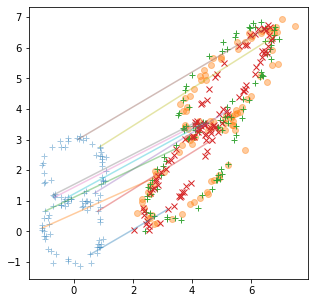

In [36]:
##############################################################################
# Plot transported samples
# ------------------------

plt.figure(1, (5, 5))
plt.clf()
plt.plot(xs[:, 0], xs[:, 1], '+', alpha=0.4)
plt.plot(xt[:, 0], xt[:, 1], 'o', alpha=0.4)
plt.plot(xst[:, 0], xst[:, 1], '+', alpha=0.9)
plt.plot(xs_adapted[:, 0], xs_adapted[:, 1], 'x', alpha=1)
#xs_adapted2 = (cder.M_ @ xs.T + cder.b_.T).T
#plt.plot(xs_adapted2[:, 0], xs_adapted2[:, 1], 'd', alpha=1)
#plt.plot(np.random.normal(size=(2,3)), np.random.normal(size=(2,3)), 'lightgray');
plt.plot(
    np.vstack([xs[::10, [0]].T, xs_adapted[::10, [0]].T]),
    np.vstack([xs[::10, [1]].T, xs_adapted[::10, [1]].T]),
    alpha=0.4);
"""
plt.plot(
    np.vstack([xs[:, [0]].T, xst[:, [0]].T]),
    np.vstack([xs[:, [1]].T, xst[:, [1]].T]),
    'lightgray', alpha=0.4);
"""
plt.show()

In [4]:
if False:
    ##############################################################################
    # Load image data
    # ---------------


    def im2mat(img):
        """Converts and image to matrix (one pixel per line)"""
        return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))


    def mat2im(X, shape):
        """Converts back a matrix to an image"""
        return X.reshape(shape)


    def minmax(img):
        return np.clip(img, 0, 1)


    # Loading images
    this_file = os.path.realpath('__file__')
    data_path = os.path.join(Path(this_file).parent, 'data')

    I1 = plt.imread(os.path.join(data_path, 'ocean_day.jpg')).astype(np.float64) / 256
    I2 = plt.imread(os.path.join(data_path, 'ocean_sunset.jpg')).astype(np.float64) / 256


    X1 = im2mat(I1)
    X2 = im2mat(I2)

    ##############################################################################
    # Estimate mapping and adapt
    # ----------------------------

    mapping = ot.da.LinearTransport()

    mapping.fit(Xs=X1, Xt=X2)


    xst = mapping.transform(Xs=X1)
    xts = mapping.inverse_transform(Xt=X2)

    I1t = minmax(mat2im(xst, I1.shape))
    I2t = minmax(mat2im(xts, I2.shape))

    # %%


    ##############################################################################
    # Plot transformed images
    # -----------------------

    plt.figure(2, figsize=(10, 7))

    plt.subplot(2, 2, 1)
    plt.imshow(I1)
    plt.axis('off')
    plt.title('Im. 1')

    plt.subplot(2, 2, 2)
    plt.imshow(I2)
    plt.axis('off')
    plt.title('Im. 2')

    plt.subplot(2, 2, 3)
    plt.imshow(I1t)
    plt.axis('off')
    plt.title('Mapping Im. 1')

    plt.subplot(2, 2, 4)
    plt.imshow(I2t)
    plt.axis('off')
    plt.title('Inverse mapping Im. 2');

In [5]:
a = np.random.normal(size=(8,2))

In [6]:
np.sum(a @ a.T)

18.17269828643498

In [7]:
np.sum(a) ** 2

29.01206375132708

In [8]:
cder.M_

array([[0.69853628, 0.94061747],
       [0.17221   , 1.5787177 ]])

In [9]:
around = np.round(a, 0)
np.unique(around, axis=0, return_counts=True)

(array([[-2., -3.],
        [-2.,  1.],
        [-1., -1.],
        [-1.,  1.],
        [ 0.,  0.],
        [-0.,  2.],
        [ 1., -2.],
        [ 1.,  1.]]),
 array([1, 1, 1, 1, 1, 1, 1, 1]))

In [10]:
around

array([[ 1., -2.],
       [-1.,  1.],
       [ 0.,  0.],
       [ 1.,  1.],
       [-2.,  1.],
       [-1., -1.],
       [-0.,  2.],
       [-2., -3.]])

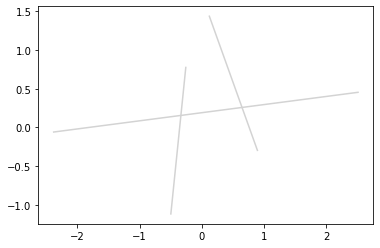

In [11]:
plt.plot(np.random.normal(size=(2,3)), np.random.normal(size=(2,3)), 'lightgray');

In [12]:
np.random.normal(size=(4,)).reshape(1, -1).shape

(1, 4)

In [13]:
np.linalg.det(cder.M_)

0.9408078533760826

In [14]:
cder.b_.reshape(1, -1).shape

(1, 2)

In [15]:
xs_adapted2 = np.zeros_like(xs)
for i in range(xs.shape[0]):
    xs_adapted2[i, :] = cder.M_ @ xs[i,:] + cder.b_
    if i % 100 == 0:
        print(f"{xs[i,:]} {xs_adapted2[i, :]}")

[0.71785173 1.26503863] [5.17687541 3.92887035]


In [16]:
np.max(np.abs(xs_adapted - xs_adapted2))

8.881784197001252e-16

In [17]:
cder.M_

array([[0.69853628, 0.94061747],
       [0.17221   , 1.5787177 ]])

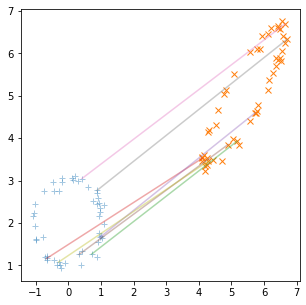

In [18]:
plt.figure(1, (5, 5))
plt.clf()
plt.plot(xs[:n // 2, 0], xs[:n // 2, 1], '+', alpha=0.4)
#plt.plot(xt[:n // 2, 0], xt[:n // 2, 1], 'o', alpha=0.4)
#plt.plot(xst[:n // 2, 0], xst[:n // 2, 1], '+', alpha=0.9)
plt.plot(xs_adapted[:n // 2, 0], xs_adapted[:n // 2, 1], 'x', alpha=1)
#xs_adapted2 = (cder.M_ @ xs.T + cder.b_.T).T
#plt.plot(xs_adapted2[:, 0], xs_adapted2[:, 1], 'd', alpha=1)
#plt.plot(np.random.normal(size=(2,3)), np.random.normal(size=(2,3)), 'lightgray');
plt.plot(
    np.vstack([xs[:n // 2:8, [0]].T, xs_adapted[:n // 2:8, [0]].T]),
    np.vstack([xs[:n // 2:8, [1]].T, xs_adapted[:n // 2:8, [1]].T]),
    alpha=0.4);
"""
plt.plot(
    np.vstack([xs[:, [0]].T, xst[:, [0]].T]),
    np.vstack([xs[:, [1]].T, xst[:, [1]].T]),
    'lightgray', alpha=0.4);
"""
plt.show()

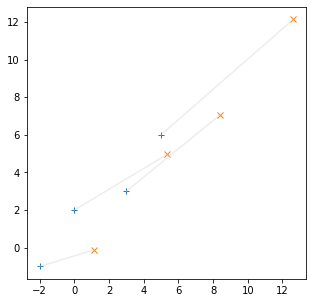

In [19]:
xsgram = np.array([
    [-2., -1],
    [0., 2.],
    [3., 3.],
    [5., 6.],
])
xsgram_adapted = cder.transform(xsgram)
plt.figure(1, (5, 5))
plt.clf()
plt.plot(xsgram[:, 0], xsgram[:, 1], '+')
plt.plot(xsgram_adapted[:, 0], xsgram_adapted[:, 1], 'x')
plt.plot(
    np.vstack([xsgram[:, [0]].T, xsgram_adapted[:, [0]].T]),
    np.vstack([xsgram[:, [1]].T, xsgram_adapted[:, [1]].T]),
    'lightgray', alpha=0.4);

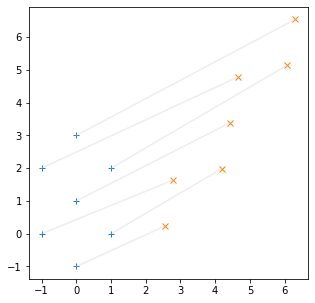

In [20]:
xsgram = np.array([
    [0., -1],
    [0., 1.],
    [0., 3.],
    [-1., 0.],
    [-1., 2.],
    [1., 0.],
    [1., 2.],
])
xsgram_adapted = cder.transform(xsgram)
plt.figure(1, (5, 5))
plt.clf()
plt.plot(xsgram[:, 0], xsgram[:, 1], '+')
plt.plot(xsgram_adapted[:, 0], xsgram_adapted[:, 1], 'x')
plt.plot(
    np.vstack([xsgram[:, [0]].T, xsgram_adapted[:, [0]].T]),
    np.vstack([xsgram[:, [1]].T, xsgram_adapted[:, [1]].T]),
    'lightgray', alpha=0.4);

In [21]:
np.linalg.det(cder.M_)

0.9408078533760826

In [22]:
be.shape

(1, 2)

In [23]:
Ae.shape

(2, 2)

In [24]:
xs.shape

(100, 2)

In [25]:
np.max(np.abs((xs @ Ae + be) - (xs.dot(Ae)+be)))

0.0

In [26]:
np.max(np.abs(((Ae.T @ xs.T).T + be) - (xs.dot(Ae)+be)))

0.0

In [27]:
cder.M_

array([[0.69853628, 0.94061747],
       [0.17221   , 1.5787177 ]])

In [28]:
Ae.T

array([[1.38969577, 0.57882414],
       [0.57882414, 1.50904589]])

In [29]:
A.T

array([[1.5, 0.7],
       [0.7, 1.5]])

In [30]:
np.ones(3)

array([1., 1., 1.])

In [31]:
import torch

In [32]:
torch.ones(3,)

tensor([1., 1., 1.])

In [33]:
np.sqrt(45 * 50)

47.43416490252569

In [34]:
type(round(1.4))

int

In [35]:
np.std(ys)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U6'), dtype('<U6')) -> None

In [ ]:
from copy import deepcopy
deepcopy(None) or {}

In [ ]:
import numpy as np
np.diag(np.random.normal(0, 1, 4))

In [ ]:
3 != 4